In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real
import sobol_seq  
from concurrent.futures import ThreadPoolExecutor
from scipy.optimize import minimize
import logging

In [2]:
# Sobol sequence sampler for better parameter initialization
def sobol_sampler(dim, num_samples):
    samples = sobol_seq.i4_sobol_generate(dim, num_samples)  # Generate Sobol sequence
    return samples * 2 * np.pi  # Scale to [0, 2π] range

# Step 1: Monte Carlo Search (Global Exploration)
def monte_carlo_search(psi, num_params, num_samples, overlap_func):
    sobol_samples = sobol_sampler(num_params, num_samples)  # Generate Sobol sequence

    def evaluate_sample(params):
        return overlap_func(psi, *params)  # Explicitly use the passed overlap function

    # Run sequentially for debugging (use ProcessPoolExecutor for parallelism)
    overlaps = [evaluate_sample(params) for params in sobol_samples]

    best_idx = np.argmin(overlaps)  # Get index of best candidate
    return sobol_samples[best_idx]  # Return best parameter set


def refine_with_gradient(psi, initial_guess, overlap_func, method="BFGS"):
    result = minimize(
        lambda params: overlap_func(psi, *params),  # Explicitly pass overlap function
        initial_guess,
        method=method
    )
    return result.fun, result.x  # Return best GE and optimized parameters


def hybrid_optimization(psi, num_params, num_samples, overlap_func):
    best_mc_guess = monte_carlo_search(psi, num_params, num_samples, overlap_func)  # Pass function
    best_GE, best_params = refine_with_gradient(psi, best_mc_guess, overlap_func)  # Pass function
    return best_GE, best_params


# Two-qubit state (Bipartite entanglement)

Target state:  $$
|\psi_p\rangle = \sqrt{p} |00\rangle + \sqrt{1-p} |11\rangle
$$

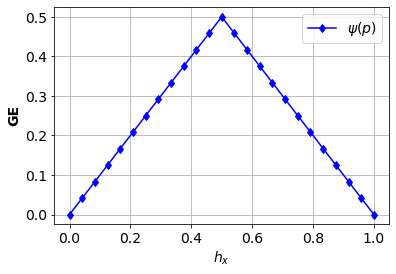

In [3]:
# Define the device (2 qubits)
dev = qml.device("default.qubit", wires=2)

# Define a quantum circuit 
@qml.qnode(dev)
def rotate_x_z(phi1, beta1, phi2, beta2):
    # subsystem A
    qml.RX(phi1, wires=0)  # First qubit rotation
    qml.RZ(beta1, wires=0)  # First qubit phase 
     # subsystem B
    qml.RX(phi2, wires=1)  # Second qubit rotation
    qml.RZ(beta2, wires=1)  # Second qubit phase shift
    return qml.state() # Tensor product of state(A) and state(B) (seperable)

# Overlap function: fidelity between target state and unentangled state
def overlap(psi, phi1, beta1, phi2, beta2):
    state = rotate_x_z(phi1, beta1, phi2, beta2)
    overlap_value = np.abs(np.vdot(psi, state)) ** 2
    return 1 - overlap_value  # Minimize (1 - fidelity)

# Target state |ψ_p>
def psi_p(p):
    return np.array([np.sqrt(p), 0, 0, np.sqrt(1 - p)])

# Evaluate GE for a range of p values
p_values = np.linspace(0, 1, 25)
num_samples = 5000  # Number of Sobol samples

optimal_values1 = []

# Perform hybrid optimization for each p
num_params=4
for p in p_values:
    best_overlap, _ = hybrid_optimization(psi_p(p) , num_params, num_samples, overlap)
    optimal_values1.append(best_overlap)
    
# Plot the results
plt.plot(p_values, optimal_values1, 'b-d', label="$\psi(p)$") 
plt.xlabel(r"$h_{x}$", fontsize=14, fontweight='bold')
plt.ylabel("GE", fontsize=14, fontweight='bold')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()


# Three-qubit state (Tripartite entanglement)

Target state: 
$$|\tilde{W}W\rangle = \sqrt{p} |W\rangle + \sqrt{1-p} e^{i\phi} |\tilde{W}\rangle \equiv \sqrt{p} |W\rangle + \sqrt{1-p} |\tilde{W}\rangle$$
with
$$|W\rangle = \frac{1}{\sqrt{3}} \Big( |001\rangle + |010\rangle + |100\rangle \Big)$$
and
$$|\tilde{W}\rangle = \frac{1}{\sqrt{3}} \Big( |011\rangle + |101\rangle + |110\rangle \Big).$$

In [4]:
# Define the device (3 qubits)
dev = qml.device("default.qubit", wires=3)

# Define a quantum circuit
@qml.qnode(dev)
def rotate_x_z(phi1):
    # subsystem A
    qml.RX(phi1, wires=0)  # First qubit rotation
    qml.RZ(np.pi/2, wires=0)  # First qubit phase 
     # subsystem B
    qml.RX(phi1, wires=1)  # Second qubit rotation
    qml.RZ(np.pi/2, wires=1)  # Second qubit phase shift
    # subsystem C
    qml.RX(phi1, wires=2)  # third qubit rotation
    qml.RZ(np.pi/2, wires=2)  # third qubit phase shift
    return qml.state() # Tensor product of state(A) and state(B) and state(C) (seperable)

# Overlap function: fidelity between target state and unentangled state
def overlap1(psi, phi1):
    state = rotate_x_z(phi1)
    overlap_value = 1-np.abs(np.vdot(psi, state)) ** 2
    return overlap_value  # Minimize (1 - fidelity)

# Target state |ψ_p>
def W_s(p):
    return np.array([0, np.sqrt(p/3), np.sqrt(p/3), np.sqrt((1 - p)/3), np.sqrt(p/3), np.sqrt((1 - p)/3), np.sqrt((1 - p)/3), 0])

# Evaluate GE for a range of p values
p_values = np.linspace(0, 1, 25)
num_samples = 5000  # Number of Sobol samples

optimal_values2 = []

# Perform hybrid optimization for each p
num_params=1
for p in p_values:
    best_overlap, _ = hybrid_optimization(W_s(p) , num_params, num_samples, overlap1)
    optimal_values2.append(best_overlap)



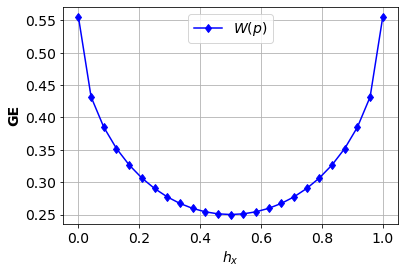

In [5]:
# Plot the results
plt.plot(p_values, optimal_values2, 'b-d', label="$W(p)$") 
plt.xlabel(r"$h_{x}$", fontsize=14, fontweight='bold')
plt.ylabel("GE", fontsize=14, fontweight='bold')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()

# Three-qubit state (Tripartite entanglement)

Target state:

$$|GW(s, \phi)\rangle = \sqrt{p} |GHZ\rangle + \sqrt{1-p} e^{i\phi} |W\rangle$$

with $|GHZ\rangle=\frac{1}{\sqrt{2}}( |000\rangle+|111\rangle)$.

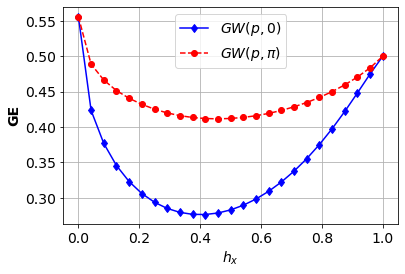

In [6]:
# Define the device (3 qubits)
dev = qml.device("default.qubit", wires=3)

# Define the quantum circuit
@qml.qnode(dev)
def rotate_x_z(phi1, beta1, phi2, beta2, phi3, beta3):
    qml.RX(phi1, wires=0)
    qml.RZ(beta1, wires=0)
    qml.RX(phi2, wires=1)
    qml.RZ(beta2, wires=1)
    qml.RX(phi3, wires=2)
    qml.RZ(beta3, wires=2)
    return qml.state()

# Overlap function: fidelity between target state and quantum state
def overlap2(psi, phi1, beta1, phi2, beta2, phi3, beta3):
    state = rotate_x_z(phi1, beta1, phi2, beta2, phi3, beta3)
    overlap_value = np.abs(np.vdot(psi, state)) ** 2
    return 1 - overlap_value  # Minimize (1 - fidelity)

# Target states
def W_s_plus(p):
    return np.array([np.sqrt(p / 2), np.sqrt((1 - p) / 3), np.sqrt((1 - p) / 3), 0, np.sqrt((1 - p) / 3), 0, 0, np.sqrt(p / 2)])

def W_s_minus(p):
    return np.array([np.sqrt(p / 2), -np.sqrt((1 - p) / 3), -np.sqrt((1 - p) / 3), 0, -np.sqrt((1 - p) / 3), 0, 0, np.sqrt(p / 2)])

# Evaluate GE for a range of p values
p_values = np.linspace(0, 1, 25)
num_samples = 5000  # Number of Sobol samples

optimal_values_plus = []
optimal_values_minus = []

# Perform hybrid optimization for each p
num_params=6
for p in p_values:
    best_overlap_plus, _ = hybrid_optimization(W_s_plus(p), num_params, num_samples, overlap2)
    optimal_values_plus.append(best_overlap_plus)
    
    best_overlap_minus, _ = hybrid_optimization(W_s_minus(p), num_params, num_samples, overlap2)
    optimal_values_minus.append(best_overlap_minus)

# Plot the results
plt.plot(p_values, optimal_values_plus, 'b-d', label="$GW(p, 0)$") 
plt.plot(p_values, optimal_values_minus, 'r--o', label="$GW(p, \pi)$")  
plt.xlabel(r"$h_{x}$", fontsize=14, fontweight='bold')
plt.ylabel("GE", fontsize=14, fontweight='bold')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()


# Four-Qubit State  (Bipartite entanglement)

Subsystem A={Qubit 1, Qubit 3} and Subsystem B={Qubit 2, Qubit 4}

Target State:

$$|BB\rangle = \frac{\sqrt{s} + \sqrt{1 - s}}{2} |0000\rangle + \frac{\sqrt{s} - \sqrt{1 - s}}{2} |0101\rangle + \frac{\sqrt{s} - \sqrt{1 - s}}{2} |1010\rangle + \frac{\sqrt{s} + \sqrt{1 - s}}{2} |1111\rangle$$

$$|BB\rangle = \sqrt{s}|\psi_{13}^{+}\rangle|\psi_{24}^{+}\rangle + \sqrt{1 - s}|\psi_{13}^{-}\rangle|\psi_{24}^{-}\rangle$$

where $|\psi_{xy}^{\pm}\rangle=\frac{1}{\sqrt{2}}( |00\rangle\pm|11\rangle)$ are Bell states corresponding to pair of qubits x and y

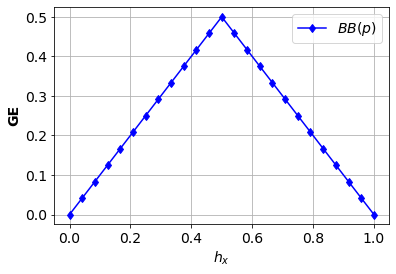

In [7]:
# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")
logger = logging.getLogger()

# Define the device (4 qubits)
dev = qml.device("default.qubit", wires=4)

# Quantum circuit
@qml.qnode(dev)
def rotate_x_z(phi1, beta1, phi2, beta2, phi3, beta3, phi4, beta4):
    qml.RX(phi1, wires=0)
    qml.RX(phi2, wires=1)
    qml.RX(phi3, wires=2)
    qml.RX(phi4, wires=3)
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[1, 3])
    qml.RZ(beta1, wires=0)
    qml.RZ(beta2, wires=1)
    qml.RZ(beta3, wires=2)
    qml.RZ(beta4, wires=3)
    return qml.state()

# Overlap function (1 - fidelity)
def overlap3(psi, *params):
    state = rotate_x_z(*params)
    fidelity = np.abs(np.vdot(psi, state)) ** 2
    return 1 - fidelity  # Minimize (1 - fidelity)

# Generate target state W_s(s)
def BB(s):
    state = np.array([
        (np.sqrt(s) + np.sqrt(1 - s)) / 2, 0, 0, 0, 0,
        (np.sqrt(s) - np.sqrt(1 - s)) / 2, 0, 0, 0, 0,
        (np.sqrt(s) - np.sqrt(1 - s)) / 2, 0, 0, 0, 0,
        (np.sqrt(s) + np.sqrt(1 - s)) / 2
    ])
    return state

# Evaluate GE for a range of p values
p_values = np.linspace(0, 1, 25)
num_samples = 5000  # Number of Sobol samples

optimal_values3 = []

# Perform hybrid optimization for each p
num_params=8
for p in p_values:
    best_overlap, _ = hybrid_optimization(BB(p) , num_params, num_samples, overlap3)
    optimal_values3.append(best_overlap)
    
# Plot the results
plt.plot(p_values, optimal_values3, 'b-d', label="$BB(p)$") 
plt.xlabel(r"$h_{x}$", fontsize=14, fontweight='bold')
plt.ylabel("GE", fontsize=14, fontweight='bold')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()



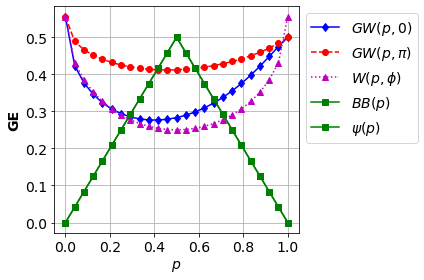

In [8]:
plt.plot(p_values, optimal_values_plus, 'b-d', label=r"$GW(p, 0)$")   # Blue, diamond
plt.plot(p_values, optimal_values_minus, 'r--o', label=r"$GW(p, \pi)$")  # Red, dashed, circle
plt.plot(p_values, optimal_values2, 'm:^', label=r"$W(p, \phi)$")    # Magenta, dotted, triangle
plt.plot(p_values, optimal_values3, 'g-s', label=r"$BB(p)$")   # Green, solid, square
plt.plot(p_values, optimal_values1, 'g-s', label=r"$\psi(p)$")  # Green, solid, square

plt.xlabel(r"$p$", fontsize=14, fontweight='bold')
plt.ylabel("GE", fontsize=14, fontweight='bold')

# Move legend outside the plot
plt.legend(fontsize=14, loc="upper left", bbox_to_anchor=(1, 1))  

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.tight_layout()  # Adjust layout to fit everything
plt.show()